# BaarleNet [Part 6d].ipynb

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

def get_relu_joint(weight_1, weight_2, bias, extent=1):
    if np.abs(weight_2) < 1e-8: 
        x_intercept = -bias / weight_1
        return [[x_intercept, -extent], [x_intercept, extent]] if -extent <= x_intercept <= extent else []
    elif np.abs(weight_1) < 1e-8:
        y_intercept = -bias / weight_2
        return [[-extent, y_intercept], [extent, y_intercept]] if -extent <= y_intercept <= extent else []
    else:
        points = []
        for x in [-extent, extent]:
            y = (-x * weight_1 - bias) / weight_2
            if -extent <= y <= extent: points.append([x, y])
        for y in [-extent, extent]:
            x = (-y * weight_2 - bias) / weight_1
            if -extent <= x <= extent: points.append([x, y])
        unique_points = []
        for p in points:
            is_duplicate = False
            for existing in unique_points:
                if abs(p[0] - existing[0]) < 1e-8 and abs(p[1] - existing[1]) < 1e-8:
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_points.append(p)
        return unique_points

def viz_map_with_predictions(ax, map, X, y):
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    
    X_denorm=denorm(X[:1000,:])
    # plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)
    labels=y[:1000]
    y_hat=torch.argmax(model(torch.tensor(X[:1000,:]).float()).detach(),1).numpy()
    tp_mask=np.logical_and(labels==1, y_hat==1)
    fp_mask=np.logical_and(labels==0, y_hat==1)
    fn_mask=np.logical_and(labels==1, y_hat==0)
    tn_mask=np.logical_and(labels==0, y_hat==0)
    ax.scatter(X_denorm[tp_mask,0], X_denorm[tp_mask,1], c='g', s=3, alpha=0.8)
    ax.scatter(X_denorm[fp_mask,0], X_denorm[fp_mask,1], c='r', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[fn_mask,0], X_denorm[fn_mask,1], c='orange', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[tn_mask,0], X_denorm[tn_mask,1], c='purple', marker='o', s=5, alpha=0.8)

def extract_weights_to_numpy(model, layer_indices=None, output_file=None):
    """
    Extract PyTorch model weights and biases to NumPy arrays with copy-paste ready code.
    
    Args:
        model: PyTorch model
        layer_indices: List of layer indices to extract (if None, extracts all layers with weights)
        output_file: Optional file path to save the output code
    
    Returns:
        String containing the NumPy array definitions ready to copy-paste
    """
    
    lines = []
    lines.append("import numpy as np\n")
    
    # Auto-detect layers if not specified
    if layer_indices is None:
        layer_indices = []
        for i, layer in enumerate(model.model):
            if hasattr(layer, 'weight'):
                layer_indices.append(i)
    
    # Extract weights and biases
    weight_counter = 1
    for idx in layer_indices:
        layer = model.model[idx]
        
        if hasattr(layer, 'weight'):
            # Extract weight
            weight_np = layer.weight.detach().numpy()
            weight_repr = np.array2string(weight_np, 
                                        separator=', ', 
                                        formatter={'float_kind': lambda x: f"{x:g}"})
            lines.append(f"w{weight_counter} = np.array({weight_repr}, dtype=np.float32)")
            
            # Extract bias if it exists
            if hasattr(layer, 'bias') and layer.bias is not None:
                bias_np = layer.bias.detach().numpy()
                bias_repr = np.array2string(bias_np, 
                                          separator=', ', 
                                          formatter={'float_kind': lambda x: f"{x:g}"})
                lines.append(f"b{weight_counter} = np.array({bias_repr}, dtype=np.float32)")
            
            weight_counter += 1
    
    output = '\n'.join(lines)
    
    # Save to file if specified
    if output_file:
        with open(output_file, 'w') as f:
            f.write(output)
        print(f"Weights saved to {output_file}")
    
    # Print to console
    print(output)
    return output

def extract_specific_layers(model, layer_specs):
    """
    Extract specific layers with custom naming.
    
    Args:
        model: PyTorch model
        layer_specs: List of tuples (layer_index, weight_name, bias_name)
                    e.g., [(0, 'w1', 'b1'), (2, 'w2', 'b2')]
    
    Returns:
        String containing the NumPy array definitions
    """
    
    lines = []
    lines.append("import numpy as np\n")
    
    for layer_idx, weight_name, bias_name in layer_specs:
        layer = model.model[layer_idx]
        
        if hasattr(layer, 'weight'):
            # Extract weight
            weight_np = layer.weight.detach().numpy()
            weight_repr = np.array2string(weight_np, 
                                        separator=', ', 
                                        formatter={'float_kind': lambda x: f"{x:g}"})
            lines.append(f"{weight_name} = np.array({weight_repr}, dtype=np.float32)")
            
            # Extract bias if it exists and bias_name is provided
            if bias_name and hasattr(layer, 'bias') and layer.bias is not None:
                bias_np = layer.bias.detach().numpy()
                bias_repr = np.array2string(bias_np, 
                                          separator=', ', 
                                          formatter={'float_kind': lambda x: f"{x:g}"})
                lines.append(f"{bias_name} = np.array({bias_repr}, dtype=np.float32)")
    
    output = '\n'.join(lines)
    print(output)
    return output

In [3]:
def get_second_layer_boundaries(model, extent=1):
    """
    Analytically solve for second layer ReLU boundaries
    Returns list of line segments for each second layer neuron
    """
    
    # Get layer weights and biases
    W1 = model.model[0].weight.detach().numpy()  # Shape: (2, 2)
    b1 = model.model[0].bias.detach().numpy()    # Shape: (2,)
    W2 = model.model[2].weight.detach().numpy()  # Shape: (2, 2) 
    b2 = model.model[2].bias.detach().numpy()    # Shape: (2,)
    
    # First, get the first layer ReLU boundaries
    first_layer_boundaries = []
    for i in range(2):
        boundary = get_relu_joint(W1[i,0], W1[i,1], b1[i], extent)
        first_layer_boundaries.append(boundary)
    
    # Define the regions created by first layer boundaries
    # Each region is defined by which first layer neurons are active
    regions = [
        (False, False),  # Both neurons off
        (True, False),   # First neuron on, second off
        (False, True),   # First neuron off, second on  
        (True, True)     # Both neurons on
    ]
    
    second_layer_boundaries = []
    
    # For each second layer neuron
    for neuron_idx in range(2):
        neuron_boundaries = []
        
        # For each region defined by first layer
        for region_mask in regions:
            # In this region, the second layer pre-activation is:
            # h2_pre = W2[neuron_idx, 0] * (W1[0,:] * x + b1[0]) * region_mask[0] + 
            #          W2[neuron_idx, 1] * (W1[1,:] * x + b1[1]) * region_mask[1] + 
            #          b2[neuron_idx]
            
            # Collect active terms
            active_weight = np.zeros(2)  # Coefficients for [x, y]
            active_bias = b2[neuron_idx]
            
            for i in range(2):
                if region_mask[i]:  # If this first layer neuron is active
                    active_weight += W2[neuron_idx, i] * W1[i, :]
                    active_bias += W2[neuron_idx, i] * b1[i]
            
            # Now solve: active_weight[0] * x + active_weight[1] * y + active_bias = 0
            boundary = get_relu_joint(active_weight[0], active_weight[1], active_bias, extent)
            
            if boundary:
                # Check if this boundary segment is actually within the region
                # We need to verify that the boundary points satisfy the region constraints
                valid_segments = []
                
                for seg_start, seg_end in zip(boundary[:-1], boundary[1:]):
                    # Check if segment is within the region defined by first layer
                    # Sample a point in the middle of the segment
                    mid_point = [(seg_start[0] + seg_end[0])/2, (seg_start[1] + seg_end[1])/2]
                    
                    # Check if this point satisfies the region constraints
                    point_in_region = True
                    for i in range(2):
                        first_layer_activation = W1[i,0] * mid_point[0] + W1[i,1] * mid_point[1] + b1[i]
                        is_active = first_layer_activation > 0
                        if is_active != region_mask[i]:
                            point_in_region = False
                            break
                    
                    if point_in_region:
                        valid_segments.append([seg_start, seg_end])
                
                neuron_boundaries.extend(valid_segments)
        
        second_layer_boundaries.append(neuron_boundaries)
    
    return second_layer_boundaries

def plot_second_layer_boundaries_analytical(ax, model):
    """Plot analytically computed second layer boundaries"""
    
    boundaries = get_second_layer_boundaries(model)
    
    colors = ['red', 'blue']
    for neuron_idx, neuron_boundaries in enumerate(boundaries):
        for segment in neuron_boundaries:
            if len(segment) == 2:  # Valid line segment
                seg_denorm = denorm(np.array(segment))
                ax.plot([seg_denorm[0][0], seg_denorm[1][0]], 
                       [seg_denorm[0][1], seg_denorm[1][1]], 
                       color=colors[neuron_idx], linewidth=2, alpha=0.8,
                       linestyle='dashed', label=f'Layer 2 Neuron {neuron_idx}')

# Simpler version that focuses on the boundary intersections
def get_second_layer_boundaries_simple(model, extent=1):
    """
    Simplified approach: compute boundary in each quadrant defined by first layer
    """
    W1 = model.model[0].weight.detach().numpy()
    b1 = model.model[0].bias.detach().numpy()
    W2 = model.model[2].weight.detach().numpy()
    b2 = model.model[2].bias.detach().numpy()
    
    boundaries = []
    
    # For each second layer neuron
    for neuron_idx in range(2):
        neuron_boundaries = []
        
        # Sample points in a grid and find where the second layer neuron crosses zero
        # But do it analytically by solving the piecewise linear equation
        
        # The key insight: in each region, the equation is linear
        # Region 1: both first layer neurons off
        # h2 = b2[neuron_idx]
        # This gives no boundary unless b2[neuron_idx] = 0
        
        # Region 2: first neuron on, second off  
        # h2 = W2[neuron_idx,0] * (W1[0,0]*x + W1[0,1]*y + b1[0]) + b2[neuron_idx]
        # Set to 0 and solve for the line
        if True:  # Always try this region
            w_eff = W2[neuron_idx, 0] * W1[0, :]
            b_eff = W2[neuron_idx, 0] * b1[0] + b2[neuron_idx]
            boundary = get_relu_joint(w_eff[0], w_eff[1], b_eff, extent)
            if boundary:
                neuron_boundaries.append(boundary)
        
        # Region 3: first neuron off, second on
        if True:
            w_eff = W2[neuron_idx, 1] * W1[1, :]
            b_eff = W2[neuron_idx, 1] * b1[1] + b2[neuron_idx]
            boundary = get_relu_joint(w_eff[0], w_eff[1], b_eff, extent)
            if boundary:
                neuron_boundaries.append(boundary)
        
        # Region 4: both neurons on
        if True:
            w_eff = W2[neuron_idx, 0] * W1[0, :] + W2[neuron_idx, 1] * W1[1, :]
            b_eff = W2[neuron_idx, 0] * b1[0] + W2[neuron_idx, 1] * b1[1] + b2[neuron_idx]
            boundary = get_relu_joint(w_eff[0], w_eff[1], b_eff, extent)
            if boundary:
                neuron_boundaries.append(boundary)
        
        boundaries.append(neuron_boundaries)
    
    return boundaries

# Usage:
def plot_all_boundaries(ax, model):
    """Plot both first and second layer boundaries"""
    
    # First layer (solid lines)
    for neuron_idx in range(2):
        w1 = model.model[0].weight[neuron_idx, 0].item()
        w2 = model.model[0].weight[neuron_idx, 1].item()
        b = model.model[0].bias[neuron_idx].item()
        
        joint = get_relu_joint(w1, w2, b, extent=1)
        if joint:
            joint_denorm = denorm(np.array(joint))
            ax.plot([joint_denorm[0][0], joint_denorm[1][0]], 
                   [joint_denorm[0][1], joint_denorm[1][1]], 
                   color=f'C{neuron_idx}', linewidth=2, alpha=0.8,
                   label=f'Layer 1 Neuron {neuron_idx}')
    
    # Second layer (dashed lines)
    plot_second_layer_boundaries_analytical(ax, model)

In [4]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<50
belgium_region=((map-belgium_color)**2).sum(-1)<10000



b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
num_points_to_sample=10000 #10000
belgium_coords_sample=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords_sample=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]
X_sample=np.vstack((netherlands_coords_sample, belgium_coords_sample))
y_sample=np.concatenate((np.zeros(len(belgium_coords_sample)), np.ones(len(netherlands_coords_sample)))).astype('int')


#Skip sampling train on all. 
belgium_coords=belgium_coords_all
netherlands_coords=netherlands_coords_all

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

In [5]:
X.shape

(855665, 2)

In [6]:
belgium_coords_all.shape

(166715, 2)

In [7]:
# plt.scatter(X[:,0], X[:,1], c=y, s=1, alpha=0.3); plt.axis('square');

In [8]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

 ## ALOT ALOT
 

In [9]:
# # random_seed = 36
# num_neurons = 10000
# batch_size = 32  # Adjust batch size as needed

# accuracies=[]
# for random_seed in range(31, 64):
#     torch.manual_seed(random_seed)  
#     X_tensor = torch.FloatTensor(X)
#     y_tensor = torch.tensor(y)
    
#     # Create dataset and dataloader for minibatching
#     dataset = TensorDataset(X_tensor, y_tensor)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
#     # Initialize model and optimizer
#     model = BaarleNet([num_neurons])
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.005)
#     num_epochs = 20
    
#     for epoch in range(num_epochs):
#         epoch_loss = 0.0
#         num_batches = 0
        
#         for batch_X, batch_y in dataloader:
#             # Forward pass
#             outputs = model(batch_X)
#             loss = criterion(outputs, batch_y)
            
#             # Backward and optimize
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             epoch_loss += loss.item()
#             num_batches += 1
        

#     with torch.no_grad():
#         outputs_batch = model(X_tensor)
#         accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
#     print(f'Random Seed [{random_seed}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

In [10]:
device='cuda'

In [11]:
random_seed = 55 #31
num_neurons = 100000
batch_size = 32  # Adjust batch size as needed

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([num_neurons]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)
num_epochs = 400

for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 200) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(torch.FloatTensor(X_sample).to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == torch.tensor(y_sample).to(device)).sum().item() / len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

  0%|▏                                       | 2/400 [03:19<11:01:05, 99.66s/it]

Epoch [2/400], Loss: 0.1454, Accuracy: 0.0211


  1%|▍                                       | 4/400 [06:40<10:58:51, 99.83s/it]

Epoch [4/400], Loss: 0.1336, Accuracy: 0.0217


  2%|▌                                       | 6/400 [09:55<10:49:26, 98.90s/it]

Epoch [6/400], Loss: 0.1269, Accuracy: 0.0216


  2%|▊                                       | 8/400 [13:11<10:44:10, 98.60s/it]

Epoch [8/400], Loss: 0.1219, Accuracy: 0.0216


  2%|▉                                      | 10/400 [16:31<10:45:33, 99.32s/it]

Epoch [10/400], Loss: 0.1191, Accuracy: 0.0214


  3%|█▏                                    | 12/400 [19:54<10:47:50, 100.18s/it]

Epoch [12/400], Loss: 0.1155, Accuracy: 0.0213


  4%|█▎                                    | 14/400 [23:14<10:45:32, 100.34s/it]

Epoch [14/400], Loss: 0.1123, Accuracy: 0.0215


  4%|█▌                                     | 16/400 [26:34<10:39:48, 99.97s/it]

Epoch [16/400], Loss: 0.1096, Accuracy: 0.0219


  4%|█▊                                     | 18/400 [29:52<10:33:26, 99.49s/it]

Epoch [18/400], Loss: 0.1075, Accuracy: 0.0221


  5%|█▉                                     | 20/400 [33:11<10:28:49, 99.29s/it]

Epoch [20/400], Loss: 0.1053, Accuracy: 0.0218


  6%|██▏                                    | 22/400 [36:31<10:27:27, 99.60s/it]

Epoch [22/400], Loss: 0.1029, Accuracy: 0.0217


  6%|██▎                                    | 24/400 [39:49<10:21:02, 99.10s/it]

Epoch [24/400], Loss: 0.1011, Accuracy: 0.0216


  6%|██▌                                    | 26/400 [43:09<10:19:51, 99.44s/it]

Epoch [26/400], Loss: 0.0994, Accuracy: 0.0220


  7%|██▋                                   | 28/400 [46:30<10:21:45, 100.28s/it]

Epoch [28/400], Loss: 0.0984, Accuracy: 0.0219


  8%|██▉                                    | 30/400 [49:47<10:12:50, 99.38s/it]

Epoch [30/400], Loss: 0.0968, Accuracy: 0.0220


  8%|███                                    | 32/400 [53:06<10:10:55, 99.61s/it]

Epoch [32/400], Loss: 0.0955, Accuracy: 0.0218


  8%|███▏                                  | 34/400 [56:27<10:10:13, 100.04s/it]

Epoch [34/400], Loss: 0.0945, Accuracy: 0.0225


  9%|███▌                                    | 36/400 [59:40<9:54:16, 97.96s/it]

Epoch [36/400], Loss: 0.0933, Accuracy: 0.0217


 10%|███▍                                | 38/400 [1:03:04<10:03:57, 100.10s/it]

Epoch [38/400], Loss: 0.0917, Accuracy: 0.0222


 10%|███▊                                  | 40/400 [1:06:22<9:57:02, 99.51s/it]

Epoch [40/400], Loss: 0.0905, Accuracy: 0.0222


 10%|███▉                                  | 42/400 [1:09:41<9:54:06, 99.57s/it]

Epoch [42/400], Loss: 0.0898, Accuracy: 0.0217


 11%|████                                 | 44/400 [1:13:03<9:55:06, 100.30s/it]

Epoch [44/400], Loss: 0.0893, Accuracy: 0.0218


 12%|████▎                                | 46/400 [1:16:28<9:57:52, 101.33s/it]

Epoch [46/400], Loss: 0.0880, Accuracy: 0.0223


 12%|████▌                                 | 48/400 [1:19:42<9:41:07, 99.06s/it]

Epoch [48/400], Loss: 0.0875, Accuracy: 0.0221


 12%|████▊                                 | 50/400 [1:22:57<9:35:38, 98.68s/it]

Epoch [50/400], Loss: 0.0868, Accuracy: 0.0219


 13%|████▉                                 | 52/400 [1:26:17<9:36:36, 99.41s/it]

Epoch [52/400], Loss: 0.0856, Accuracy: 0.0221


 14%|█████▏                                | 54/400 [1:29:16<9:02:55, 94.15s/it]

Epoch [54/400], Loss: 0.0853, Accuracy: 0.0218


 14%|█████▎                                | 56/400 [1:32:43<9:27:22, 98.96s/it]

Epoch [56/400], Loss: 0.0844, Accuracy: 0.0225


 14%|█████▌                                | 58/400 [1:36:06<9:29:26, 99.90s/it]

Epoch [58/400], Loss: 0.0835, Accuracy: 0.0224


 15%|█████▌                               | 60/400 [1:39:27<9:28:50, 100.38s/it]

Epoch [60/400], Loss: 0.0835, Accuracy: 0.0224


 16%|█████▉                                | 62/400 [1:42:43<9:17:48, 99.02s/it]

Epoch [62/400], Loss: 0.0826, Accuracy: 0.0224


 16%|█████▉                               | 64/400 [1:46:06<9:20:20, 100.06s/it]

Epoch [64/400], Loss: 0.0823, Accuracy: 0.0224


 16%|██████▎                               | 66/400 [1:49:20<9:06:36, 98.19s/it]

Epoch [66/400], Loss: 0.0813, Accuracy: 0.0225


 17%|██████▍                               | 68/400 [1:52:40<9:09:04, 99.23s/it]

Epoch [68/400], Loss: 0.0810, Accuracy: 0.0223


 18%|██████▍                              | 70/400 [1:56:02<9:11:10, 100.21s/it]

Epoch [70/400], Loss: 0.0803, Accuracy: 0.0204


 18%|██████▊                               | 72/400 [1:59:19<9:02:09, 99.17s/it]

Epoch [72/400], Loss: 0.0795, Accuracy: 0.0222


 18%|███████                               | 74/400 [2:02:37<8:59:04, 99.22s/it]

Epoch [74/400], Loss: 0.0799, Accuracy: 0.0221


 19%|███████▏                              | 76/400 [2:05:56<8:56:47, 99.41s/it]

Epoch [76/400], Loss: 0.0792, Accuracy: 0.0223


 20%|███████▍                              | 78/400 [2:09:08<8:45:10, 97.86s/it]

Epoch [78/400], Loss: 0.0783, Accuracy: 0.0224


 20%|███████▌                              | 80/400 [2:12:30<8:49:13, 99.23s/it]

Epoch [80/400], Loss: 0.0782, Accuracy: 0.0220


 20%|███████▊                              | 82/400 [2:15:49<8:47:18, 99.49s/it]

Epoch [82/400], Loss: 0.0776, Accuracy: 0.0219


 21%|███████▊                             | 84/400 [2:19:12<8:49:31, 100.54s/it]

Epoch [84/400], Loss: 0.0774, Accuracy: 0.0225


 22%|████████▏                             | 86/400 [2:22:31<8:42:47, 99.90s/it]

Epoch [86/400], Loss: 0.0765, Accuracy: 0.0224


 22%|████████▏                            | 88/400 [2:25:52<8:41:50, 100.35s/it]

Epoch [88/400], Loss: 0.0769, Accuracy: 0.0207


 22%|████████▎                            | 90/400 [2:29:16<8:43:36, 101.34s/it]

Epoch [90/400], Loss: 0.0761, Accuracy: 0.0221


 23%|████████▌                            | 92/400 [2:32:40<8:41:11, 101.53s/it]

Epoch [92/400], Loss: 0.0763, Accuracy: 0.0226


 24%|████████▋                            | 94/400 [2:35:59<8:33:00, 100.59s/it]

Epoch [94/400], Loss: 0.0757, Accuracy: 0.0223


 24%|█████████                             | 96/400 [2:39:18<8:26:17, 99.93s/it]

Epoch [96/400], Loss: 0.0751, Accuracy: 0.0221


 24%|█████████                            | 98/400 [2:42:42<8:27:03, 100.74s/it]

Epoch [98/400], Loss: 0.0754, Accuracy: 0.0219


 25%|█████████                           | 100/400 [2:46:03<8:23:29, 100.70s/it]

Epoch [100/400], Loss: 0.0756, Accuracy: 0.0222


 26%|█████████▏                          | 102/400 [2:49:24<8:19:08, 100.50s/it]

Epoch [102/400], Loss: 0.0741, Accuracy: 0.0226


 26%|█████████▌                           | 104/400 [2:52:37<8:05:59, 98.51s/it]

Epoch [104/400], Loss: 0.0745, Accuracy: 0.0225


 26%|█████████▊                           | 106/400 [2:55:53<8:00:11, 98.00s/it]

Epoch [106/400], Loss: 0.0745, Accuracy: 0.0214


 27%|█████████▉                           | 108/400 [2:59:11<7:59:29, 98.53s/it]

Epoch [108/400], Loss: 0.0734, Accuracy: 0.0225


 28%|█████████▉                          | 110/400 [3:02:35<8:04:42, 100.29s/it]

Epoch [110/400], Loss: 0.0737, Accuracy: 0.0223


 28%|██████████                          | 112/400 [3:05:55<8:00:47, 100.17s/it]

Epoch [112/400], Loss: 0.0730, Accuracy: 0.0221


 28%|██████████▎                         | 114/400 [3:09:14<7:57:05, 100.09s/it]

Epoch [114/400], Loss: 0.0736, Accuracy: 0.0226


 29%|██████████▋                          | 116/400 [3:12:31<7:50:07, 99.32s/it]

Epoch [116/400], Loss: 0.0726, Accuracy: 0.0225


 30%|██████████▌                         | 118/400 [3:15:54<7:51:53, 100.40s/it]

Epoch [118/400], Loss: 0.0730, Accuracy: 0.0223


 30%|███████████                          | 120/400 [3:19:08<7:41:08, 98.82s/it]

Epoch [120/400], Loss: 0.0721, Accuracy: 0.0227


 30%|███████████▎                         | 122/400 [3:22:22<7:34:33, 98.10s/it]

Epoch [122/400], Loss: 0.0723, Accuracy: 0.0226


 31%|███████████▏                        | 124/400 [3:25:47<7:41:20, 100.29s/it]

Epoch [124/400], Loss: 0.0716, Accuracy: 0.0226


 32%|███████████▋                         | 126/400 [3:29:01<7:29:50, 98.51s/it]

Epoch [126/400], Loss: 0.0714, Accuracy: 0.0223


 32%|███████████▊                         | 128/400 [3:32:19<7:27:31, 98.72s/it]

Epoch [128/400], Loss: 0.0717, Accuracy: 0.0225


 32%|████████████                         | 130/400 [3:35:31<7:16:58, 97.10s/it]

Epoch [130/400], Loss: 0.0712, Accuracy: 0.0224


 33%|████████████▏                        | 132/400 [3:38:48<7:16:26, 97.71s/it]

Epoch [132/400], Loss: 0.0711, Accuracy: 0.0227


 34%|████████████▍                        | 134/400 [3:42:07<7:16:28, 98.45s/it]

Epoch [134/400], Loss: 0.0712, Accuracy: 0.0214


 34%|████████████▌                        | 136/400 [3:45:26<7:15:45, 99.04s/it]

Epoch [136/400], Loss: 0.0707, Accuracy: 0.0223


 34%|████████████▊                        | 138/400 [3:48:44<7:13:08, 99.19s/it]

Epoch [138/400], Loss: 0.0701, Accuracy: 0.0223


 35%|████████████▉                        | 140/400 [3:52:02<7:09:41, 99.16s/it]

Epoch [140/400], Loss: 0.0702, Accuracy: 0.0225


 36%|█████████████▏                       | 142/400 [3:55:18<7:03:18, 98.45s/it]

Epoch [142/400], Loss: 0.0701, Accuracy: 0.0221


 36%|█████████████▎                       | 144/400 [3:58:38<7:03:15, 99.20s/it]

Epoch [144/400], Loss: 0.0706, Accuracy: 0.0222


 36%|█████████████▌                       | 146/400 [4:01:58<7:01:33, 99.58s/it]

Epoch [146/400], Loss: 0.0699, Accuracy: 0.0226


 37%|█████████████▋                       | 148/400 [4:05:16<6:55:47, 99.00s/it]

Epoch [148/400], Loss: 0.0700, Accuracy: 0.0220


 38%|█████████████▉                       | 150/400 [4:08:34<6:52:15, 98.94s/it]

Epoch [150/400], Loss: 0.0697, Accuracy: 0.0227


 38%|██████████████                       | 152/400 [4:11:55<6:52:11, 99.72s/it]

Epoch [152/400], Loss: 0.0695, Accuracy: 0.0226


 38%|██████████████▏                      | 154/400 [4:15:13<6:48:24, 99.61s/it]

Epoch [154/400], Loss: 0.0690, Accuracy: 0.0225


 39%|██████████████▍                      | 156/400 [4:18:23<6:33:11, 96.69s/it]

Epoch [156/400], Loss: 0.0687, Accuracy: 0.0222


 40%|██████████████▌                      | 158/400 [4:21:46<6:40:09, 99.21s/it]

Epoch [158/400], Loss: 0.0685, Accuracy: 0.0224


 40%|██████████████▍                     | 160/400 [4:25:14<6:46:40, 101.67s/it]

Epoch [160/400], Loss: 0.0686, Accuracy: 0.0222


 40%|██████████████▉                      | 162/400 [4:27:58<5:59:04, 90.52s/it]

Epoch [162/400], Loss: 0.0684, Accuracy: 0.0224


 41%|███████████████▏                     | 164/400 [4:30:50<5:53:26, 89.86s/it]

Epoch [164/400], Loss: 0.0687, Accuracy: 0.0225


 42%|███████████████▎                     | 166/400 [4:33:31<5:23:30, 82.95s/it]

Epoch [166/400], Loss: 0.0689, Accuracy: 0.0225


 42%|███████████████▌                     | 168/400 [4:36:35<5:38:25, 87.52s/it]

Epoch [168/400], Loss: 0.0685, Accuracy: 0.0225


 42%|███████████████▋                     | 170/400 [4:39:49<5:56:23, 92.97s/it]

Epoch [170/400], Loss: 0.0682, Accuracy: 0.0222


 43%|███████████████▉                     | 172/400 [4:42:52<5:55:00, 93.42s/it]

Epoch [172/400], Loss: 0.0681, Accuracy: 0.0224


 44%|████████████████                     | 174/400 [4:46:22<6:13:36, 99.19s/it]

Epoch [174/400], Loss: 0.0682, Accuracy: 0.0222


 44%|███████████████▊                    | 176/400 [4:49:52<6:21:30, 102.19s/it]

Epoch [176/400], Loss: 0.0683, Accuracy: 0.0220


 44%|████████████████▍                    | 178/400 [4:53:06<6:08:33, 99.61s/it]

Epoch [178/400], Loss: 0.0676, Accuracy: 0.0227


 45%|████████████████▏                   | 180/400 [4:56:33<6:12:59, 101.72s/it]

Epoch [180/400], Loss: 0.0682, Accuracy: 0.0225


 46%|████████████████▍                   | 182/400 [5:00:02<6:14:17, 103.02s/it]

Epoch [182/400], Loss: 0.0676, Accuracy: 0.0221


 46%|████████████████▌                   | 184/400 [5:03:28<6:11:36, 103.22s/it]

Epoch [184/400], Loss: 0.0678, Accuracy: 0.0224


 46%|█████████████████▏                   | 186/400 [5:06:41<5:55:44, 99.74s/it]

Epoch [186/400], Loss: 0.0671, Accuracy: 0.0219


 47%|█████████████████▍                   | 188/400 [5:09:52<5:43:10, 97.13s/it]

Epoch [188/400], Loss: 0.0670, Accuracy: 0.0224


 48%|█████████████████▌                   | 190/400 [5:13:08<5:43:31, 98.15s/it]

Epoch [190/400], Loss: 0.0666, Accuracy: 0.0224


 48%|█████████████████▎                  | 192/400 [5:16:34<5:48:16, 100.46s/it]

Epoch [192/400], Loss: 0.0669, Accuracy: 0.0227


 48%|█████████████████▉                   | 194/400 [5:19:41<5:29:31, 95.98s/it]

Epoch [194/400], Loss: 0.0672, Accuracy: 0.0228


 49%|██████████████████▏                  | 196/400 [5:22:34<5:13:55, 92.33s/it]

Epoch [196/400], Loss: 0.0666, Accuracy: 0.0222


 50%|██████████████████▎                  | 198/400 [5:26:03<5:31:22, 98.43s/it]

Epoch [198/400], Loss: 0.0663, Accuracy: 0.0225


 50%|██████████████████▌                  | 200/400 [5:29:18<5:25:33, 97.67s/it]

Epoch [200/400], Loss: 0.0662, Accuracy: 0.0223


 50%|██████████████████▋                  | 202/400 [5:32:08<4:58:30, 90.46s/it]

Epoch [202/400], Loss: 0.0666, Accuracy: 0.0226


 51%|██████████████████▊                  | 204/400 [5:35:29<5:11:53, 95.48s/it]

Epoch [204/400], Loss: 0.0657, Accuracy: 0.0226


 52%|███████████████████                  | 206/400 [5:38:02<4:33:55, 84.72s/it]

Epoch [206/400], Loss: 0.0663, Accuracy: 0.0224


 52%|███████████████████▏                 | 208/400 [5:40:36<4:25:14, 82.89s/it]

Epoch [208/400], Loss: 0.0662, Accuracy: 0.0226


 52%|███████████████████▍                 | 210/400 [5:43:43<4:36:12, 87.23s/it]

Epoch [210/400], Loss: 0.0666, Accuracy: 0.0224


 53%|███████████████████▌                 | 212/400 [5:47:03<4:55:00, 94.15s/it]

Epoch [212/400], Loss: 0.0653, Accuracy: 0.0226


 54%|███████████████████▊                 | 214/400 [5:50:19<4:56:14, 95.56s/it]

Epoch [214/400], Loss: 0.0660, Accuracy: 0.0220


 54%|███████████████████▉                 | 216/400 [5:53:47<5:06:14, 99.86s/it]

Epoch [216/400], Loss: 0.0659, Accuracy: 0.0225


 55%|████████████████████▏                | 218/400 [5:56:48<4:49:58, 95.60s/it]

Epoch [218/400], Loss: 0.0655, Accuracy: 0.0227


 55%|████████████████████▎                | 220/400 [5:59:35<4:27:26, 89.15s/it]

Epoch [220/400], Loss: 0.0653, Accuracy: 0.0225


 56%|████████████████████▌                | 222/400 [6:02:54<4:40:01, 94.39s/it]

Epoch [222/400], Loss: 0.0655, Accuracy: 0.0228


 56%|████████████████████▋                | 224/400 [6:06:12<4:45:26, 97.31s/it]

Epoch [224/400], Loss: 0.0650, Accuracy: 0.0226


 56%|████████████████████▉                | 226/400 [6:09:31<4:46:34, 98.82s/it]

Epoch [226/400], Loss: 0.0653, Accuracy: 0.0223


 57%|████████████████████▌               | 228/400 [6:12:58<4:49:24, 100.96s/it]

Epoch [228/400], Loss: 0.0649, Accuracy: 0.0223


 57%|████████████████████▋               | 230/400 [6:16:25<4:49:14, 102.08s/it]

Epoch [230/400], Loss: 0.0647, Accuracy: 0.0226


 58%|████████████████████▉               | 232/400 [6:19:46<4:44:48, 101.72s/it]

Epoch [232/400], Loss: 0.0649, Accuracy: 0.0226


 58%|█████████████████████               | 234/400 [6:23:04<4:37:06, 100.16s/it]

Epoch [234/400], Loss: 0.0645, Accuracy: 0.0223


 59%|█████████████████████▏              | 236/400 [6:26:31<4:38:18, 101.82s/it]

Epoch [236/400], Loss: 0.0643, Accuracy: 0.0227


 60%|██████████████████████               | 238/400 [6:29:46<4:28:47, 99.55s/it]

Epoch [238/400], Loss: 0.0641, Accuracy: 0.0226


 60%|██████████████████████▏              | 240/400 [6:32:50<4:16:23, 96.15s/it]

Epoch [240/400], Loss: 0.0646, Accuracy: 0.0223


 60%|██████████████████████▍              | 242/400 [6:35:35<3:54:52, 89.19s/it]

Epoch [242/400], Loss: 0.0640, Accuracy: 0.0226


 61%|██████████████████████▌              | 244/400 [6:38:39<3:58:42, 91.81s/it]

Epoch [244/400], Loss: 0.0640, Accuracy: 0.0219


 62%|██████████████████████▊              | 246/400 [6:42:00<4:06:41, 96.11s/it]

Epoch [246/400], Loss: 0.0637, Accuracy: 0.0226


 62%|██████████████████████▉              | 248/400 [6:45:18<4:05:37, 96.96s/it]

Epoch [248/400], Loss: 0.0632, Accuracy: 0.0226


 62%|███████████████████████▏             | 250/400 [6:48:29<3:59:10, 95.67s/it]

Epoch [250/400], Loss: 0.0638, Accuracy: 0.0226


 63%|███████████████████████▎             | 252/400 [6:51:37<3:54:13, 94.96s/it]

Epoch [252/400], Loss: 0.0633, Accuracy: 0.0228


 64%|███████████████████████▍             | 254/400 [6:54:39<3:44:55, 92.43s/it]

Epoch [254/400], Loss: 0.0637, Accuracy: 0.0226


 64%|███████████████████████▋             | 256/400 [6:57:24<3:26:45, 86.15s/it]

Epoch [256/400], Loss: 0.0636, Accuracy: 0.0228


 64%|███████████████████████▊             | 258/400 [7:00:34<3:33:17, 90.12s/it]

Epoch [258/400], Loss: 0.0632, Accuracy: 0.0226


 65%|████████████████████████             | 260/400 [7:04:03<3:47:04, 97.32s/it]

Epoch [260/400], Loss: 0.0637, Accuracy: 0.0227


 66%|████████████████████████▏            | 262/400 [7:07:27<3:48:43, 99.45s/it]

Epoch [262/400], Loss: 0.0631, Accuracy: 0.0226


 66%|████████████████████████▍            | 264/400 [7:10:42<3:44:30, 99.05s/it]

Epoch [264/400], Loss: 0.0631, Accuracy: 0.0223


 66%|████████████████████████▌            | 266/400 [7:13:40<3:32:00, 94.93s/it]

Epoch [266/400], Loss: 0.0628, Accuracy: 0.0225


 67%|████████████████████████▊            | 268/400 [7:16:42<3:27:01, 94.10s/it]

Epoch [268/400], Loss: 0.0630, Accuracy: 0.0227


 68%|████████████████████████▉            | 270/400 [7:19:56<3:27:56, 95.97s/it]

Epoch [270/400], Loss: 0.0626, Accuracy: 0.0223


 68%|█████████████████████████▏           | 272/400 [7:23:10<3:26:32, 96.81s/it]

Epoch [272/400], Loss: 0.0628, Accuracy: 0.0218


 68%|█████████████████████████▎           | 274/400 [7:26:28<3:26:48, 98.48s/it]

Epoch [274/400], Loss: 0.0629, Accuracy: 0.0227


 69%|████████████████████████▊           | 276/400 [7:29:55<3:28:04, 100.68s/it]

Epoch [276/400], Loss: 0.0622, Accuracy: 0.0223


 70%|█████████████████████████           | 278/400 [7:33:24<3:28:40, 102.62s/it]

Epoch [278/400], Loss: 0.0618, Accuracy: 0.0225


 70%|█████████████████████████▏          | 280/400 [7:36:44<3:22:20, 101.17s/it]

Epoch [280/400], Loss: 0.0625, Accuracy: 0.0226


 70%|█████████████████████████▍          | 282/400 [7:40:09<3:19:54, 101.65s/it]

Epoch [282/400], Loss: 0.0621, Accuracy: 0.0225


 71%|██████████████████████████▎          | 284/400 [7:43:27<3:12:43, 99.68s/it]

Epoch [284/400], Loss: 0.0623, Accuracy: 0.0224


 72%|██████████████████████████▍          | 286/400 [7:46:31<3:00:40, 95.09s/it]

Epoch [286/400], Loss: 0.0618, Accuracy: 0.0224


 72%|██████████████████████████▋          | 288/400 [7:49:38<2:57:37, 95.16s/it]

Epoch [288/400], Loss: 0.0617, Accuracy: 0.0224


 72%|██████████████████████████▊          | 290/400 [7:52:41<2:48:50, 92.10s/it]

Epoch [290/400], Loss: 0.0620, Accuracy: 0.0224


 73%|███████████████████████████          | 292/400 [7:55:54<2:48:48, 93.78s/it]

Epoch [292/400], Loss: 0.0618, Accuracy: 0.0220


 74%|███████████████████████████▏         | 294/400 [7:59:16<2:51:49, 97.26s/it]

Epoch [294/400], Loss: 0.0617, Accuracy: 0.0225


 74%|███████████████████████████▍         | 296/400 [8:01:40<2:23:30, 82.79s/it]

Epoch [296/400], Loss: 0.0619, Accuracy: 0.0226


 74%|███████████████████████████▌         | 298/400 [8:04:39<2:26:20, 86.08s/it]

Epoch [298/400], Loss: 0.0616, Accuracy: 0.0227


 75%|███████████████████████████▊         | 300/400 [8:07:56<2:34:06, 92.46s/it]

Epoch [300/400], Loss: 0.0614, Accuracy: 0.0219


 76%|███████████████████████████▉         | 302/400 [8:11:12<2:35:15, 95.06s/it]

Epoch [302/400], Loss: 0.0618, Accuracy: 0.0224


 76%|████████████████████████████         | 304/400 [8:14:37<2:37:34, 98.49s/it]

Epoch [304/400], Loss: 0.0612, Accuracy: 0.0223


 76%|████████████████████████████▎        | 306/400 [8:17:49<2:32:21, 97.25s/it]

Epoch [306/400], Loss: 0.0610, Accuracy: 0.0227


 77%|███████████████████████████▋        | 308/400 [8:21:17<2:34:18, 100.64s/it]

Epoch [308/400], Loss: 0.0614, Accuracy: 0.0224


 78%|███████████████████████████▉        | 310/400 [8:24:43<2:32:38, 101.76s/it]

Epoch [310/400], Loss: 0.0609, Accuracy: 0.0226


 78%|████████████████████████████        | 312/400 [8:28:01<2:27:06, 100.30s/it]

Epoch [312/400], Loss: 0.0607, Accuracy: 0.0227


 78%|████████████████████████████▎       | 314/400 [8:31:26<2:25:31, 101.53s/it]

Epoch [314/400], Loss: 0.0606, Accuracy: 0.0228


 79%|████████████████████████████▍       | 316/400 [8:34:56<2:24:26, 103.17s/it]

Epoch [316/400], Loss: 0.0608, Accuracy: 0.0224


 80%|████████████████████████████▌       | 318/400 [8:38:25<2:21:52, 103.81s/it]

Epoch [318/400], Loss: 0.0609, Accuracy: 0.0218


 80%|████████████████████████████▊       | 320/400 [8:41:45<2:16:19, 102.24s/it]

Epoch [320/400], Loss: 0.0610, Accuracy: 0.0227


 80%|█████████████████████████████▊       | 322/400 [8:44:28<1:57:18, 90.24s/it]

Epoch [322/400], Loss: 0.0606, Accuracy: 0.0223


 81%|█████████████████████████████▉       | 324/400 [8:46:49<1:42:42, 81.08s/it]

Epoch [324/400], Loss: 0.0608, Accuracy: 0.0225


 82%|██████████████████████████████▏      | 326/400 [8:49:14<1:33:14, 75.60s/it]

Epoch [326/400], Loss: 0.0604, Accuracy: 0.0228


 82%|██████████████████████████████▎      | 328/400 [8:52:32<1:44:52, 87.39s/it]

Epoch [328/400], Loss: 0.0601, Accuracy: 0.0224


 82%|██████████████████████████████▌      | 330/400 [8:56:00<1:51:53, 95.91s/it]

Epoch [330/400], Loss: 0.0610, Accuracy: 0.0224


 83%|██████████████████████████████▋      | 332/400 [8:59:18<1:50:23, 97.40s/it]

Epoch [332/400], Loss: 0.0611, Accuracy: 0.0227


 84%|██████████████████████████████▉      | 334/400 [9:02:29<1:46:07, 96.48s/it]

Epoch [334/400], Loss: 0.0602, Accuracy: 0.0224


 84%|███████████████████████████████      | 336/400 [9:05:37<1:42:07, 95.74s/it]

Epoch [336/400], Loss: 0.0606, Accuracy: 0.0224


 84%|███████████████████████████████▎     | 338/400 [9:09:01<1:42:12, 98.91s/it]

Epoch [338/400], Loss: 0.0600, Accuracy: 0.0228


 85%|██████████████████████████████▌     | 340/400 [9:12:23<1:40:00, 100.01s/it]

Epoch [340/400], Loss: 0.0600, Accuracy: 0.0227


 86%|██████████████████████████████▊     | 342/400 [9:15:44<1:37:01, 100.37s/it]

Epoch [342/400], Loss: 0.0605, Accuracy: 0.0226


 86%|███████████████████████████████▊     | 344/400 [9:19:00<1:32:55, 99.57s/it]

Epoch [344/400], Loss: 0.0606, Accuracy: 0.0228


 86%|████████████████████████████████     | 346/400 [9:22:20<1:29:54, 99.89s/it]

Epoch [346/400], Loss: 0.0604, Accuracy: 0.0225


 87%|████████████████████████████████▏    | 348/400 [9:25:36<1:25:37, 98.80s/it]

Epoch [348/400], Loss: 0.0597, Accuracy: 0.0226


 88%|████████████████████████████████▍    | 350/400 [9:28:54<1:22:47, 99.35s/it]

Epoch [350/400], Loss: 0.0601, Accuracy: 0.0227


 88%|████████████████████████████████▌    | 352/400 [9:31:46<1:13:07, 91.41s/it]

Epoch [352/400], Loss: 0.0599, Accuracy: 0.0224


 88%|████████████████████████████████▋    | 354/400 [9:35:10<1:14:08, 96.70s/it]

Epoch [354/400], Loss: 0.0595, Accuracy: 0.0227


 89%|████████████████████████████████    | 356/400 [9:38:38<1:13:24, 100.11s/it]

Epoch [356/400], Loss: 0.0599, Accuracy: 0.0220


 90%|████████████████████████████████▏   | 358/400 [9:42:07<1:11:41, 102.41s/it]

Epoch [358/400], Loss: 0.0594, Accuracy: 0.0227


 90%|████████████████████████████████▍   | 360/400 [9:45:36<1:08:59, 103.49s/it]

Epoch [360/400], Loss: 0.0594, Accuracy: 0.0223


 90%|████████████████████████████████▌   | 362/400 [9:48:56<1:04:33, 101.94s/it]

Epoch [362/400], Loss: 0.0592, Accuracy: 0.0222


 91%|███████████████████████████████████▍   | 364/400 [9:52:00<58:34, 97.63s/it]

Epoch [364/400], Loss: 0.0596, Accuracy: 0.0226


 92%|███████████████████████████████████▋   | 366/400 [9:55:17<55:20, 97.66s/it]

Epoch [366/400], Loss: 0.0593, Accuracy: 0.0223


 92%|███████████████████████████████████▉   | 368/400 [9:58:26<50:51, 95.37s/it]

Epoch [368/400], Loss: 0.0592, Accuracy: 0.0225


 92%|███████████████████████████████████▏  | 370/400 [10:01:19<45:55, 91.85s/it]

Epoch [370/400], Loss: 0.0591, Accuracy: 0.0224


 93%|███████████████████████████████████▎  | 372/400 [10:04:22<42:32, 91.16s/it]

Epoch [372/400], Loss: 0.0593, Accuracy: 0.0224


 94%|███████████████████████████████████▌  | 374/400 [10:07:03<37:30, 86.54s/it]

Epoch [374/400], Loss: 0.0589, Accuracy: 0.0228


 94%|███████████████████████████████████▋  | 376/400 [10:10:28<37:55, 94.83s/it]

Epoch [376/400], Loss: 0.0589, Accuracy: 0.0216


 94%|███████████████████████████████████▉  | 378/400 [10:13:37<34:57, 95.36s/it]

Epoch [378/400], Loss: 0.0590, Accuracy: 0.0225


 95%|████████████████████████████████████  | 380/400 [10:16:58<32:36, 97.84s/it]

Epoch [380/400], Loss: 0.0587, Accuracy: 0.0227


 96%|████████████████████████████████████▎ | 382/400 [10:20:06<28:32, 95.14s/it]

Epoch [382/400], Loss: 0.0583, Accuracy: 0.0229


 96%|████████████████████████████████████▍ | 384/400 [10:23:33<26:25, 99.08s/it]

Epoch [384/400], Loss: 0.0583, Accuracy: 0.0227


 96%|████████████████████████████████████▋ | 386/400 [10:26:51<23:12, 99.44s/it]

Epoch [386/400], Loss: 0.0586, Accuracy: 0.0220


 97%|███████████████████████████████████▉ | 388/400 [10:30:13<20:02, 100.24s/it]

Epoch [388/400], Loss: 0.0591, Accuracy: 0.0224


 98%|████████████████████████████████████ | 390/400 [10:33:38<16:51, 101.14s/it]

Epoch [390/400], Loss: 0.0583, Accuracy: 0.0218


 98%|████████████████████████████████████▎| 392/400 [10:37:05<13:40, 102.62s/it]

Epoch [392/400], Loss: 0.0588, Accuracy: 0.0226


 98%|████████████████████████████████████▍| 394/400 [10:40:29<10:13, 102.18s/it]

Epoch [394/400], Loss: 0.0583, Accuracy: 0.0222


 99%|████████████████████████████████████▋| 396/400 [10:43:54<06:48, 102.04s/it]

Epoch [396/400], Loss: 0.0585, Accuracy: 0.0226


100%|█████████████████████████████████████▊| 398/400 [10:47:06<03:16, 98.31s/it]

Epoch [398/400], Loss: 0.0583, Accuracy: 0.0226


100%|██████████████████████████████████████| 400/400 [10:50:31<00:00, 97.58s/it]

Epoch [400/400], Loss: 0.0582, Accuracy: 0.0225


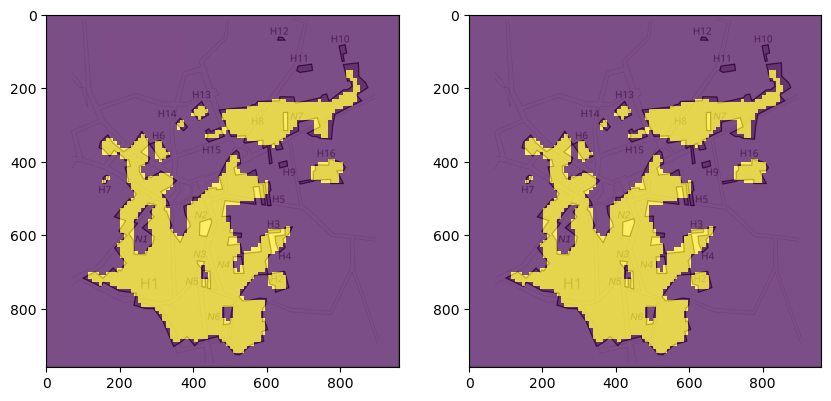

In [16]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).to(device).float())
h2 = h2.detach().cpu().numpy().reshape(100,100,2)

fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(np.argmax(h2,2)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
# plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')

In [13]:
# _=extract_weights_to_numpy(model, output_file='one_layer_alot_nuerons.py')

In [14]:
# torch.save(model,  'one_layer_100k_neurons_long.pt')

In [17]:
model

BaarleNet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=100000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100000, out_features=2, bias=True)
  )
)

Hmm ok I guess I son't save this one - pretty sure that the other 100k model was better, niether fully get the border tho!